In [2]:
import cv2
import numpy as np
from tools.ImageOperate import clahe_equalize, hist_cut
from location.GradMorph import find_barcode_by_diff
import matplotlib.pyplot as plt

# 读入图片并显示

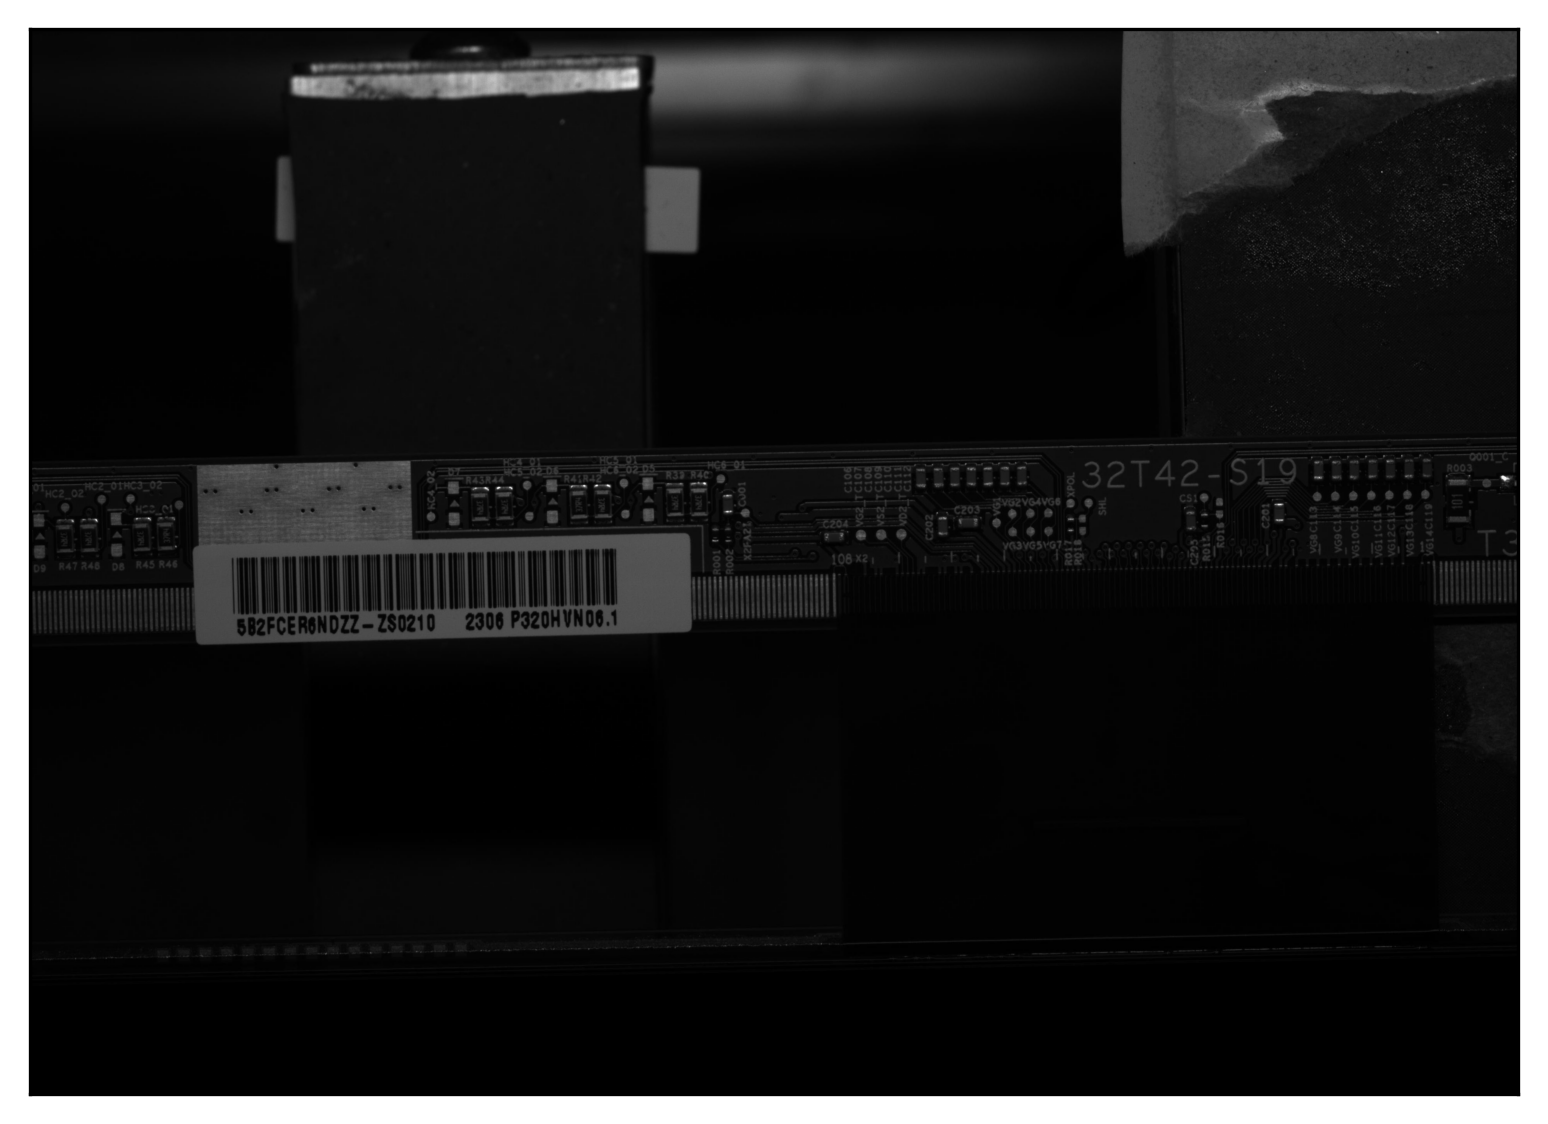

In [3]:
file = r"D:\Fenkx\Fenkx - General\AI\Dataset\BarCode\My Datasets\Test_Label\C1\5B2FCER6NDZZZS0210_NG_BarCode_Camera3_0211121738.jpg"
image = cv2.imdecode(np.fromfile(file, dtype=np.uint8), 1)
plt.figure(dpi=300)
plt.xticks([])
plt.yticks([])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## 显示原图灰度直方图

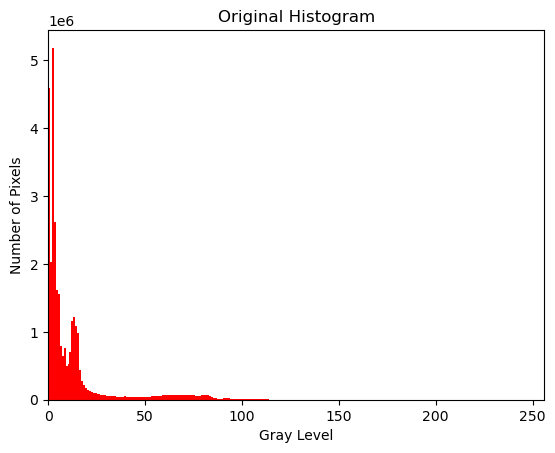

In [4]:
# 绘制原始灰度直方图
plt.hist(image.ravel(), 256, [0, 256], color='r')
plt.xlim([0, 256])
plt.xlabel('Gray Level')
plt.ylabel('Number of Pixels')
plt.title('Original Histogram')
plt.show()

# 减小尺寸

In [ ]:
from tools.ImageOperate import pyr_down


# 中值滤波，去除异常亮点

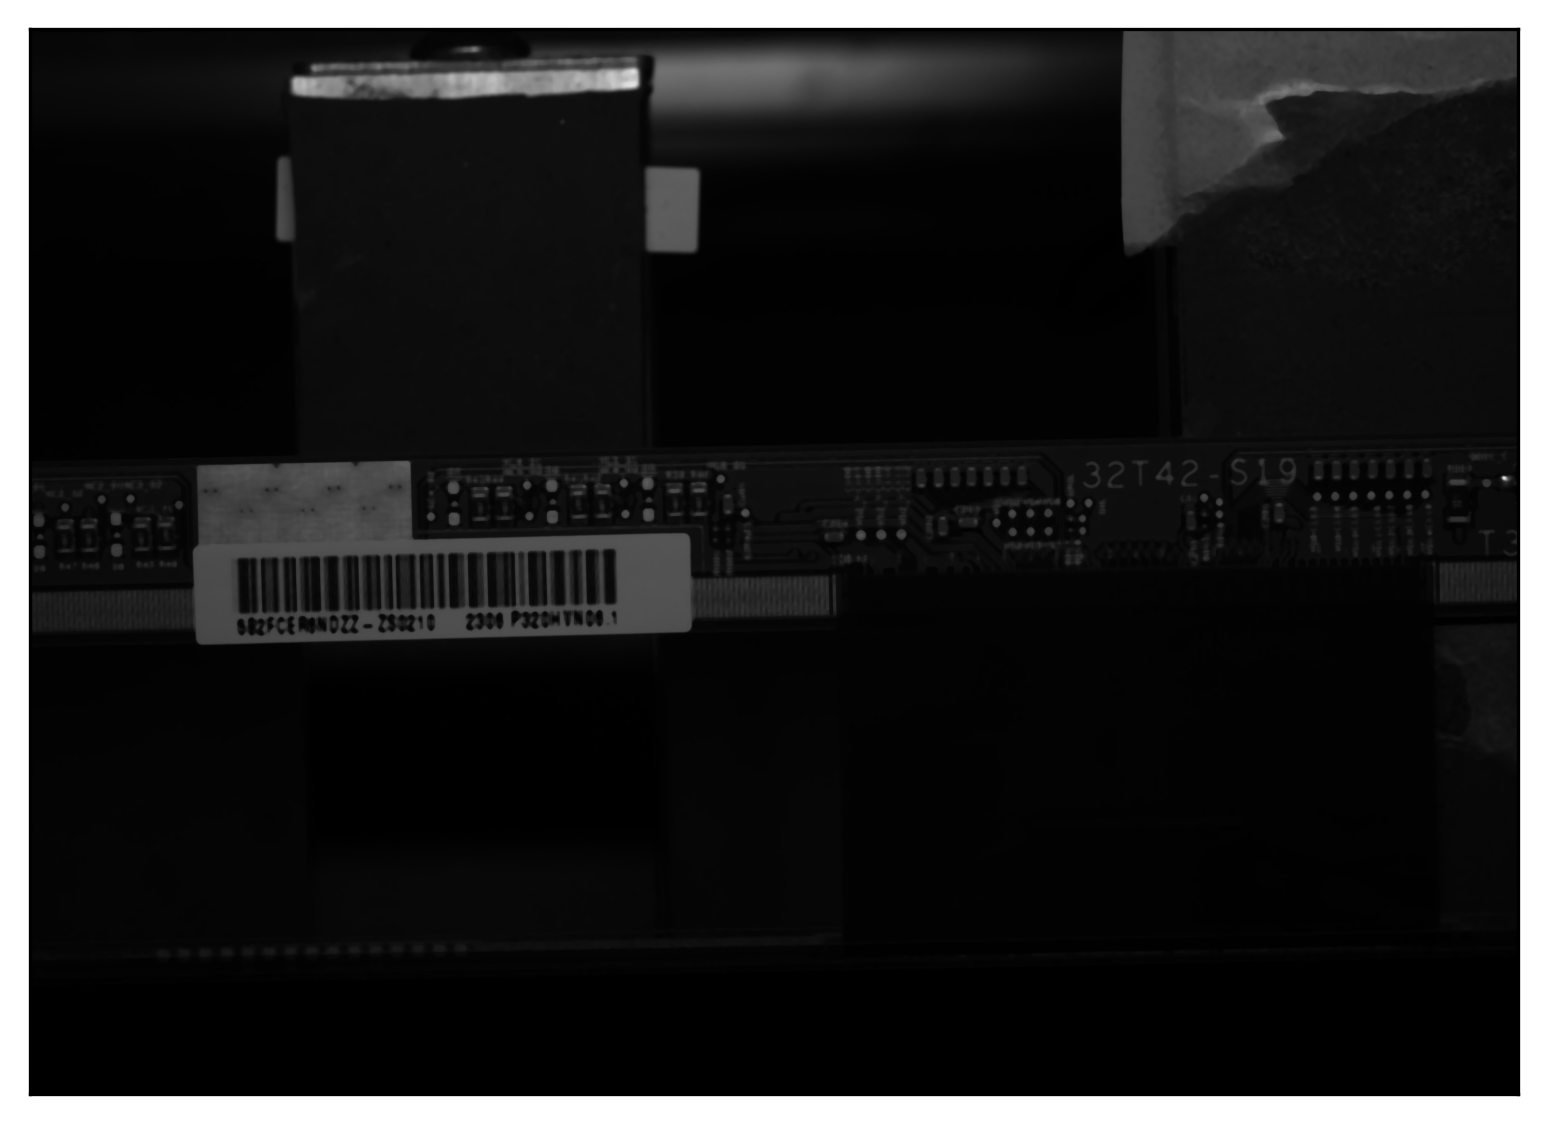

In [5]:
# 去除异常亮点,中值滤波
image_blur = cv2.medianBlur(image, 13)
plt.figure(dpi=300)
plt.xticks([])
plt.yticks([])
plt.imshow(cv2.cvtColor(image_blur, cv2.COLOR_BGR2RGB))

## 显示滤波后的灰度直方图

(1157, 3804, 0)


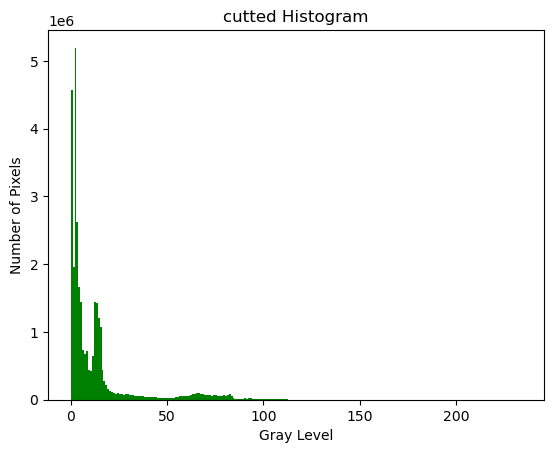

In [24]:
# 绘制去除部分直方图后的灰度直方图
max_index = np.argmax(image_blur)
print(np.unravel_index(max_index,image_blur.shape))
plt.hist(image_blur.ravel(), np.max(image_blur)+1, [0, np.max(image_blur)+1], color='g')
# plt.xlim([0, 256])
plt.xlabel('Gray Level')
plt.ylabel('Number of Pixels')
plt.title('cutted Histogram')
plt.show()

# 灰度范围映射到【0，255】

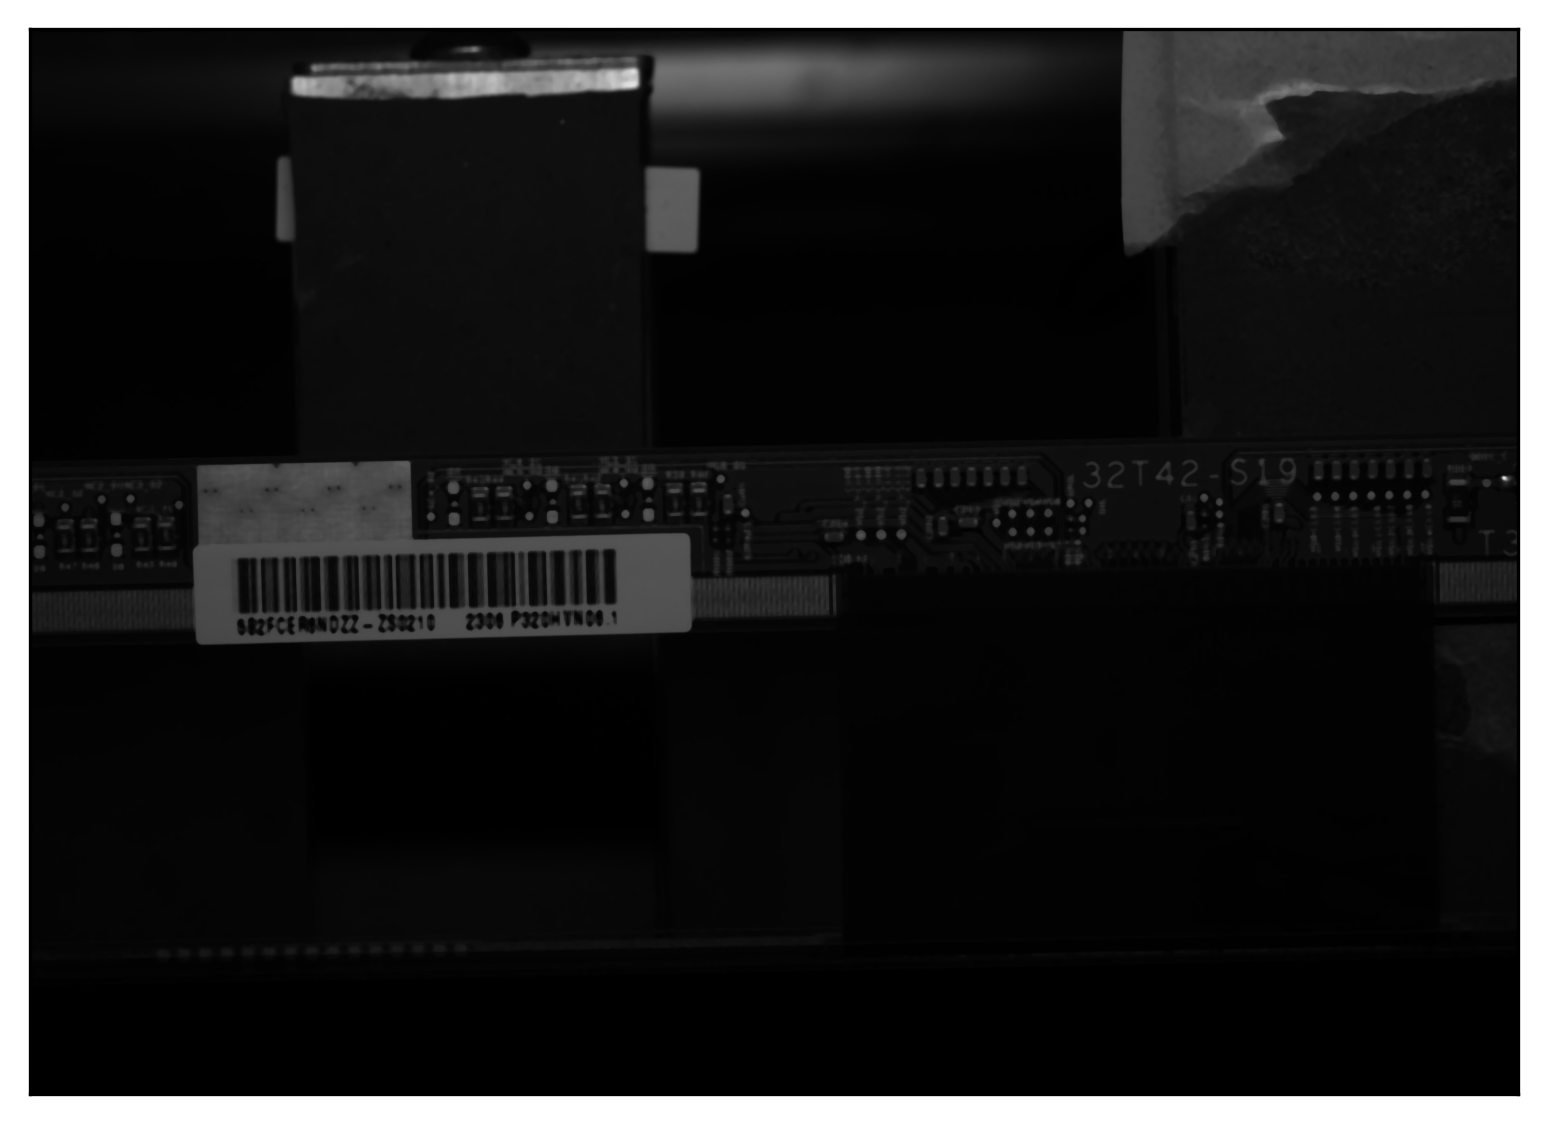

In [13]:
image_norm = cv2.normalize(image_blur, None, 0, 255, cv2.NORM_MINMAX)
plt.figure(dpi=300)
plt.xticks([])
plt.yticks([])
plt.imshow(cv2.cvtColor(image_blur, cv2.COLOR_BGR2RGB))

## 显示滤波后的灰度直方图

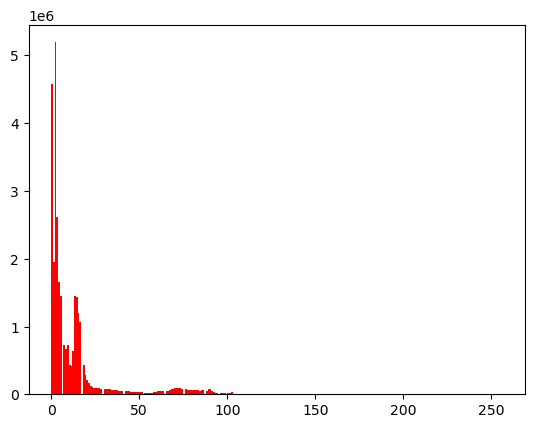

In [14]:
plt.hist(image_norm.ravel(), 256, [0, 256], color='r')
plt.show()

In [ ]:
from tools.ImageOperate import hist_remap

image_remap = hist_remap(image_norm)
plt.imshow(image_remap)
plt.hist(image_remap.ravel(), 256, [0, 256], color='r')
plt.show()

In [ ]:
image = clahe_equalize(image)
result = find_barcode_by_diff(image)
# plt.imshow(result)
cv2.namedWindow("Barcode detection", cv2.WINDOW_NORMAL)
# Display the image
cv2.imshow("Barcode detection", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import os

# Load the image
path = r'D:\Fenkx\Fenkx - General\Ubei\Test_Label1'
for index, item in enumerate(os.listdir(path)):
	file = os.path.join(path, item)
	if os.path.isfile(file):
		image = cv2.imdecode(np.fromfile(file, dtype=np.uint8), 1)  # 支持中文路径的文件读入
		image = clahe_equalize(image)
		try:
			result = find_barcode_by_diff(image)
		except:
			pass
		finally:
			filename = os.path.splitext(item)
			new_name = filename[0] + filename[-1]
			result_path = os.path.join(path, 'result_GradMorph')
			if not os.path.exists(result_path):
				os.makedirs(result_path)
			cv2.imwrite(os.path.join(result_path, new_name), result)
print('finished!')
